# Spectra for Upper Slope 75 kHz ADCP
To create a matrix of 2-month interval, 15-minute resolution spectra for the Upper Slope ADCP.

## Imports

In [46]:
import xarray as xr
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as pldates
import numpy as np
import scipy.signal as sig
import scipy.interpolate as interp
import pandas as pd
from scipy.stats import chi2
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib notebook

## Dataset management
Merge datasets, if necessary.

In [42]:
ds = xr.open_dataset('../../Data/SlopeAll/Slope_20171021_20190516.nc')
print(ds.u)

<xarray.DataArray 'u' (time: 55001, depth: 50)>
[2750050 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2017-10-21T00:07:30.000003328 ... 2019-05-16T22:07:30
  * depth    (depth) float32 378.27 370.27 362.27 354.27 ... 2.27 -5.73 -13.73
Attributes:
    standard_name:  eastward_sea_water_velocity
    long_name:      eastward sea water velocity
    units:          meters/second


In [43]:
# Merge datasets if necessary

#ds0 =  xr.open_dataset('../../Data/SlopeAll/Slope_20171021_20181021.nc')     # first dataset
#ds1 =  xr.open_dataset('../../Data/SlopeAll/Slope_20181021_20190516.nc')     # second dataset
#ds = xr.Dataset.merge(ds0,ds1)       # merged dataset
#print(ds)                            # check merged dataset is correct

#xr.Dataset.to_netcdf(ds,path='../../Data/SlopeAll/Slope_XXX_XXX.nc')         # save desired dataset

## Time
Find specific time range and formatting. If significant NaN values then shorten series for that particular 2-month spectrum. 

New time range: 2018-01-01T00:07:30.000003328 2018-02-28T23:37:30.000000000


<IPython.core.display.Javascript object>


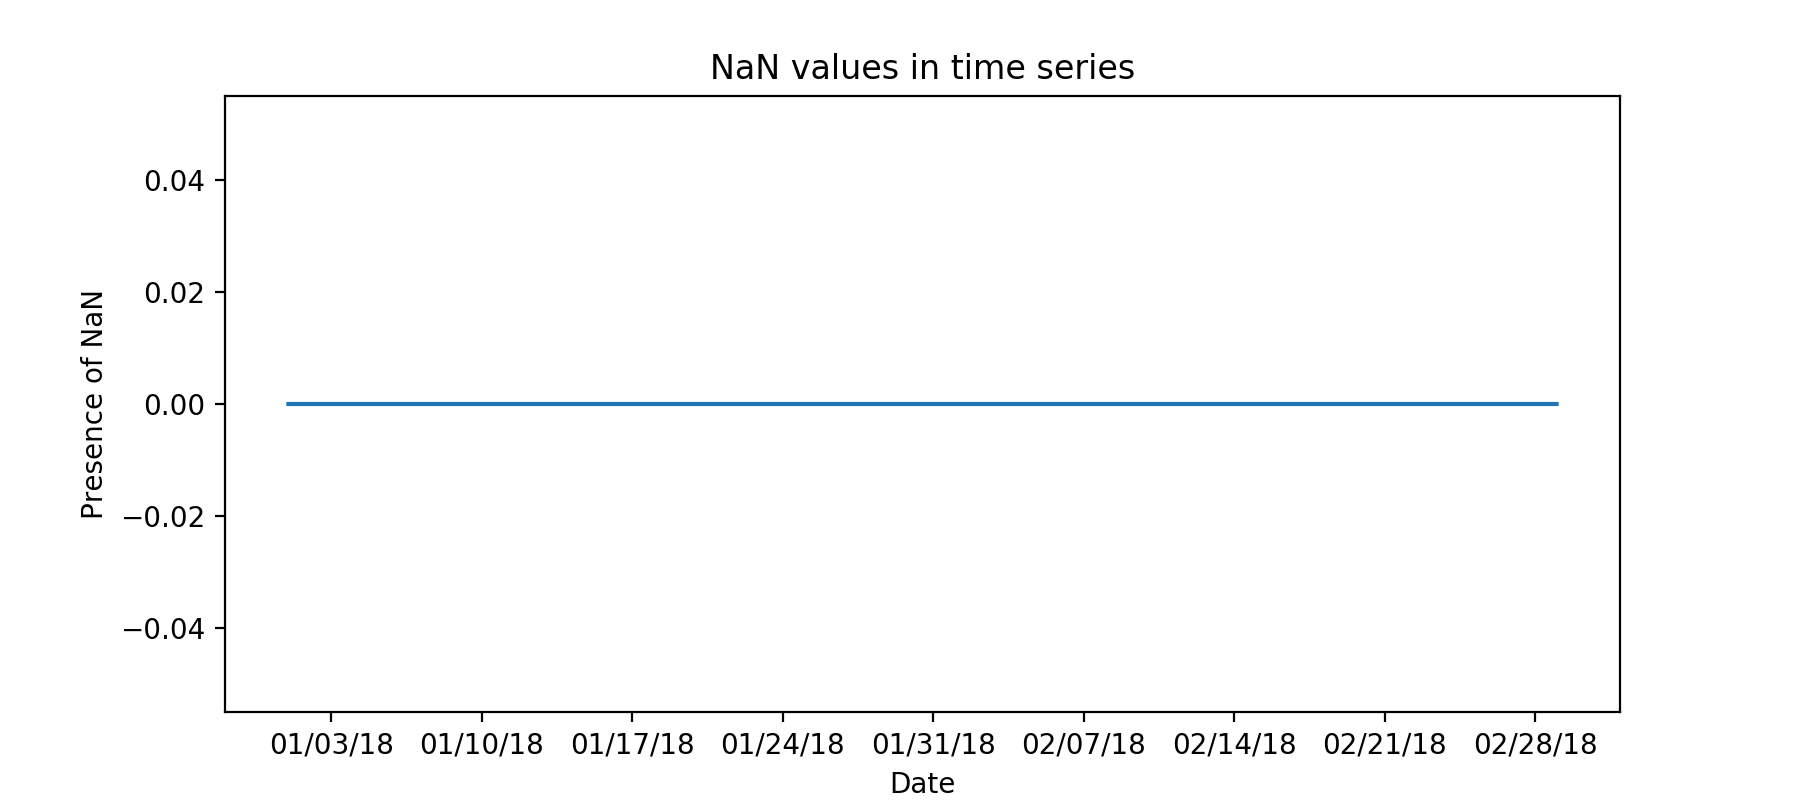

In [62]:
datestimes = pd.to_datetime(ds.time.values)        # convert to datetime from datetime64
datestimes = pd.Series(datestimes)                 # convert to pandas dataframe

start = datestimes[datestimes >= pd.datetime(2018,1,1)].index[0]     # desired start date
end = datestimes[datestimes < pd.datetime(2018,3,1)].index[-1]       # desired end date
time_total = ds.time.values[start:end]
print("New time range:",np.min(time_total),np.max(time_total))

depth_test = int(len(ds.depth)/2)                      # check new time series for significant NaN values
u_test = np.array(ds.u[start:end,depth_test])
NaN_series = np.zeros(len(u_test))
counter = 0
for i in range(len(time_total)):
    if np.isnan(u_test[i])==True:
        NaN_series[i] = 1
        counter += 1
        if counter==96:      # a day worth of NaN
            dead = i-96
            print("Time series hits trouble AFTER date:",time_total[dead])
            time = time_total[0:dead]
            end -= (len(time_total)-len(time))
            print("New time range:",np.min(time),np.max(time))
    elif np.isnan(u_test[i])==False:
        counter = 0          

fig,ax = plt.subplots(1,1,figsize=(9,4))
ax.plot(time_total,NaN_series)
ax.set_xlabel('Date')
date_form = pldates.DateFormatter("%m/%d/%y")
ax.xaxis.set_major_formatter(date_form)
#ax.set_xlim([time_total[0], time_total[-1]])
ax.set_ylabel('Presence of NaN')
ax.set_title('NaN values in time series')
plt.show()

## Depth

Find specific depth to remove depth values (unreliable data, from visual inspection of initial plots), from the top and bottom.

In [36]:
# find specific depth to remove depth values (unreliable data, from visual inspection of initial plots)
# about 100m at the top

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx     # returns index of nearest value

array = ds.depth
upval = 100        # meters
lowval = 330
upidx = find_nearest(array, upval)
lowidx = find_nearest(array,lowval)

print("Index at upper depth cutoff:", find_nearest(array, upval))
print("Value at upper depth cutoff:", abs(array[find_nearest(array, upval)]))
print('---')
print("Index at lower depth cutoff:", find_nearest(array, lowval))
print("Value at lower depth cutoff:", abs(array[find_nearest(array, lowval)]))

depth = np.array(ds.depth[lowidx:upidx+1])       # remove unwanted upper depths

print('---')
print("Length of new depth array: ", len(depth))
print('Lower limit at',-depth[0],'metres') # depth for lower PSD
print('Upper limit at',-depth[-1],'metres')# depth for upper PSD

Index at upper depth cutoff: 35
Value at upper depth cutoff: <xarray.DataArray 'depth' ()>
array(98.27, dtype=float32)
Coordinates:
    depth    float32 98.27
---
Index at lower depth cutoff: 6
Value at lower depth cutoff: <xarray.DataArray 'depth' ()>
array(330.27, dtype=float32)
Coordinates:
    depth    float32 330.27
---
Length of new depth array:  30
Lower limit at -330.27 metres
Upper limit at -98.27 metres


## Filter

Low pass Butterworth filter for 40 hours to remove 30 hour tides

In [37]:
# low pass Butterworth filter for 40 hour cut-off to remove 30 hour tides

fs = 4                # 4 samples per HOUR for entire time series
fc = 0.025            # 40 hour low pass filter cut-off
Wn = fc / (fs / 2)    # normalised cut-off frequencies
b, a = sig.butter(8, Wn,'lowpass')  # digital butterworth filter
w, h = sig.freqz(b, a)

## Rotate, interpolate, and filter data
Loop to acquire rotated original, filtered, and residual data

In [39]:
theta_along_slope = np.radians(30)                       # rotation angle in radians, 30 degrees
u_vec = ds.u[start:end,lowidx:upidx+1] + 1j*ds.v[start:end,lowidx:upidx+1]  # vector form of horizontal velocity
u_vec_new = u_vec*np.exp(-1j*theta_along_slope)          # rotated velocity vector
u_rot = np.real(u_vec_new)                             # u_new = Re(rotated vector)
v_rot = np.imag(u_vec_new)                             # v_new = Im(rotated vector)
w_new = ds.w[start:end,lowidx:upidx+1]                 # w based on time and depth filters

t = len(time)                  # number of time data points
d = len(depth)                 # number of depth data points after removing upper portion

uorig = np.empty([t,d])        # empty array for original u data
vorig = np.empty([t,d])        # empty array for original v data
worig = np.empty([t,d])        # empty array for original w data

ulp = np.empty([t,d])          # empty array for low-pass filtered u values
vlp = np.empty([t,d])          # empty array for low-pass filtered v values
wlp = np.empty([t,d])          # empty array for low-pass filtered w values

for j in range(d):             # loop to filter tides from all depths
    utemp = pd.Series(u_rot[:,j])
    uint = utemp.interpolate(method="cubic")
    uorig[:,j] = uint                    # set interpolated data to original array
    ulp[:,j] = sig.filtfilt(b, a, uint)  # set low pass array values
    
    vtemp = pd.Series(v_rot[:,j])
    vint = vtemp.interpolate(method="cubic")
    vorig[:,j] = vint                    # set interpolated data to original array
    vlp[:,j] = sig.filtfilt(b, a, vint)  # set low pass array values
    
    wtemp = pd.Series(w_new[:,j])
    wint = wtemp.interpolate(method="cubic")
    worig[:,j] = wint                    # set interpolated data to original array
    wlp[:,j] = sig.filtfilt(b, a, wint)  # set low pass array values
    
uhp = uorig - ulp
vhp = vorig - vlp
whp = worig - wlp

## Welch FFT

In [63]:
# remove mean

umlow = uorig[:,0] - np.mean(uorig[:,0]) 
vmlow = vorig[:,0] - np.mean(vorig[:,0])
wmlow = worig[:,0] - np.mean(worig[:,0])

umup = uorig[:,-1] - np.mean(uorig[:,-1]) # depth[-1] = -140 meters
vmup = vorig[:,-1] - np.mean(vorig[:,-1])
wmup = worig[:,-1] - np.mean(worig[:,-1])

In [64]:
# depth mean spectra

um_depth = np.zeros(t)  
vm_depth = np.zeros(t)
wm_depth = np.zeros(t)

for i in range(t):
    um_depth[i] = np.mean(uorig[i,:])
for i in range(t):
    vm_depth[i] = np.mean(vorig[i,:])
for i in range(t):
    wm_depth[i] = np.mean(worig[i,:])
    
um_depth -= np.mean(uorig)
vm_depth -= np.mean(vorig)
wm_depth -= np.mean(worig)

In [65]:
# Welch FFT

fs_x = 4
window_x = 'parzen'
np_len = int(len(time)/25)   # find optimal average for nperseg
nperseg_x = np_len        

umlow_f, umlow_PSD = sig.welch(umlow, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)
vmlow_f, vmlow_PSD = sig.welch(vmlow, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)
wmlow_f, wmlow_PSD = sig.welch(wmlow, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)

umup_f, umup_PSD = sig.welch(umup, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)
vmup_f, vmup_PSD = sig.welch(vmup, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)
wmup_f, wmup_PSD = sig.welch(wmup, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)

um_depth_f, um_depth_PSD = sig.welch(um_depth, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)
vm_depth_f, vm_depth_PSD = sig.welch(vm_depth, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)
wm_depth_f, wm_depth_PSD = sig.welch(wm_depth, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)

In [66]:
# error bars (95% confidence intervals)

probability = 0.95                            # calculate confidence intervals
alpha = 1 - probability        
NS = len(time) / (nperseg_x / 2)              # number of estimates, Welch
vp = (4/3)*NS                                 # for tapered windows
cp = chi2.ppf([1 - alpha / 2, alpha / 2], vp) # chi**2 distribution
cint = vp/cp                                  # interval coefficients

umlow_lower = umlow_PSD * cint[0]             # define upper and lower confidence values
umlow_upper = umlow_PSD * cint[1]
vmlow_lower = vmlow_PSD * cint[0]             # define upper and lower confidence values
vmlow_upper = vmlow_PSD * cint[1]
wmlow_lower = wmlow_PSD * cint[0]             # define upper and lower confidence values
wmlow_upper = wmlow_PSD * cint[1]

umup_lower = umup_PSD * cint[0]           # define upper and lower confidence values
umup_upper = umup_PSD * cint[1]
vmup_lower = vmup_PSD * cint[0]           # define upper and lower confidence values
vmup_upper = vmup_PSD * cint[1]
wmup_lower = wmup_PSD * cint[0]           # define upper and lower confidence values
wmup_upper = wmup_PSD * cint[1]

## Save spectra***
Saves current 2-month spectra to file, to later be compiled into a single dataset.

In [67]:
#np.save?

# Plots

## Spectra

### Comparitive Spectra

<IPython.core.display.Javascript object>


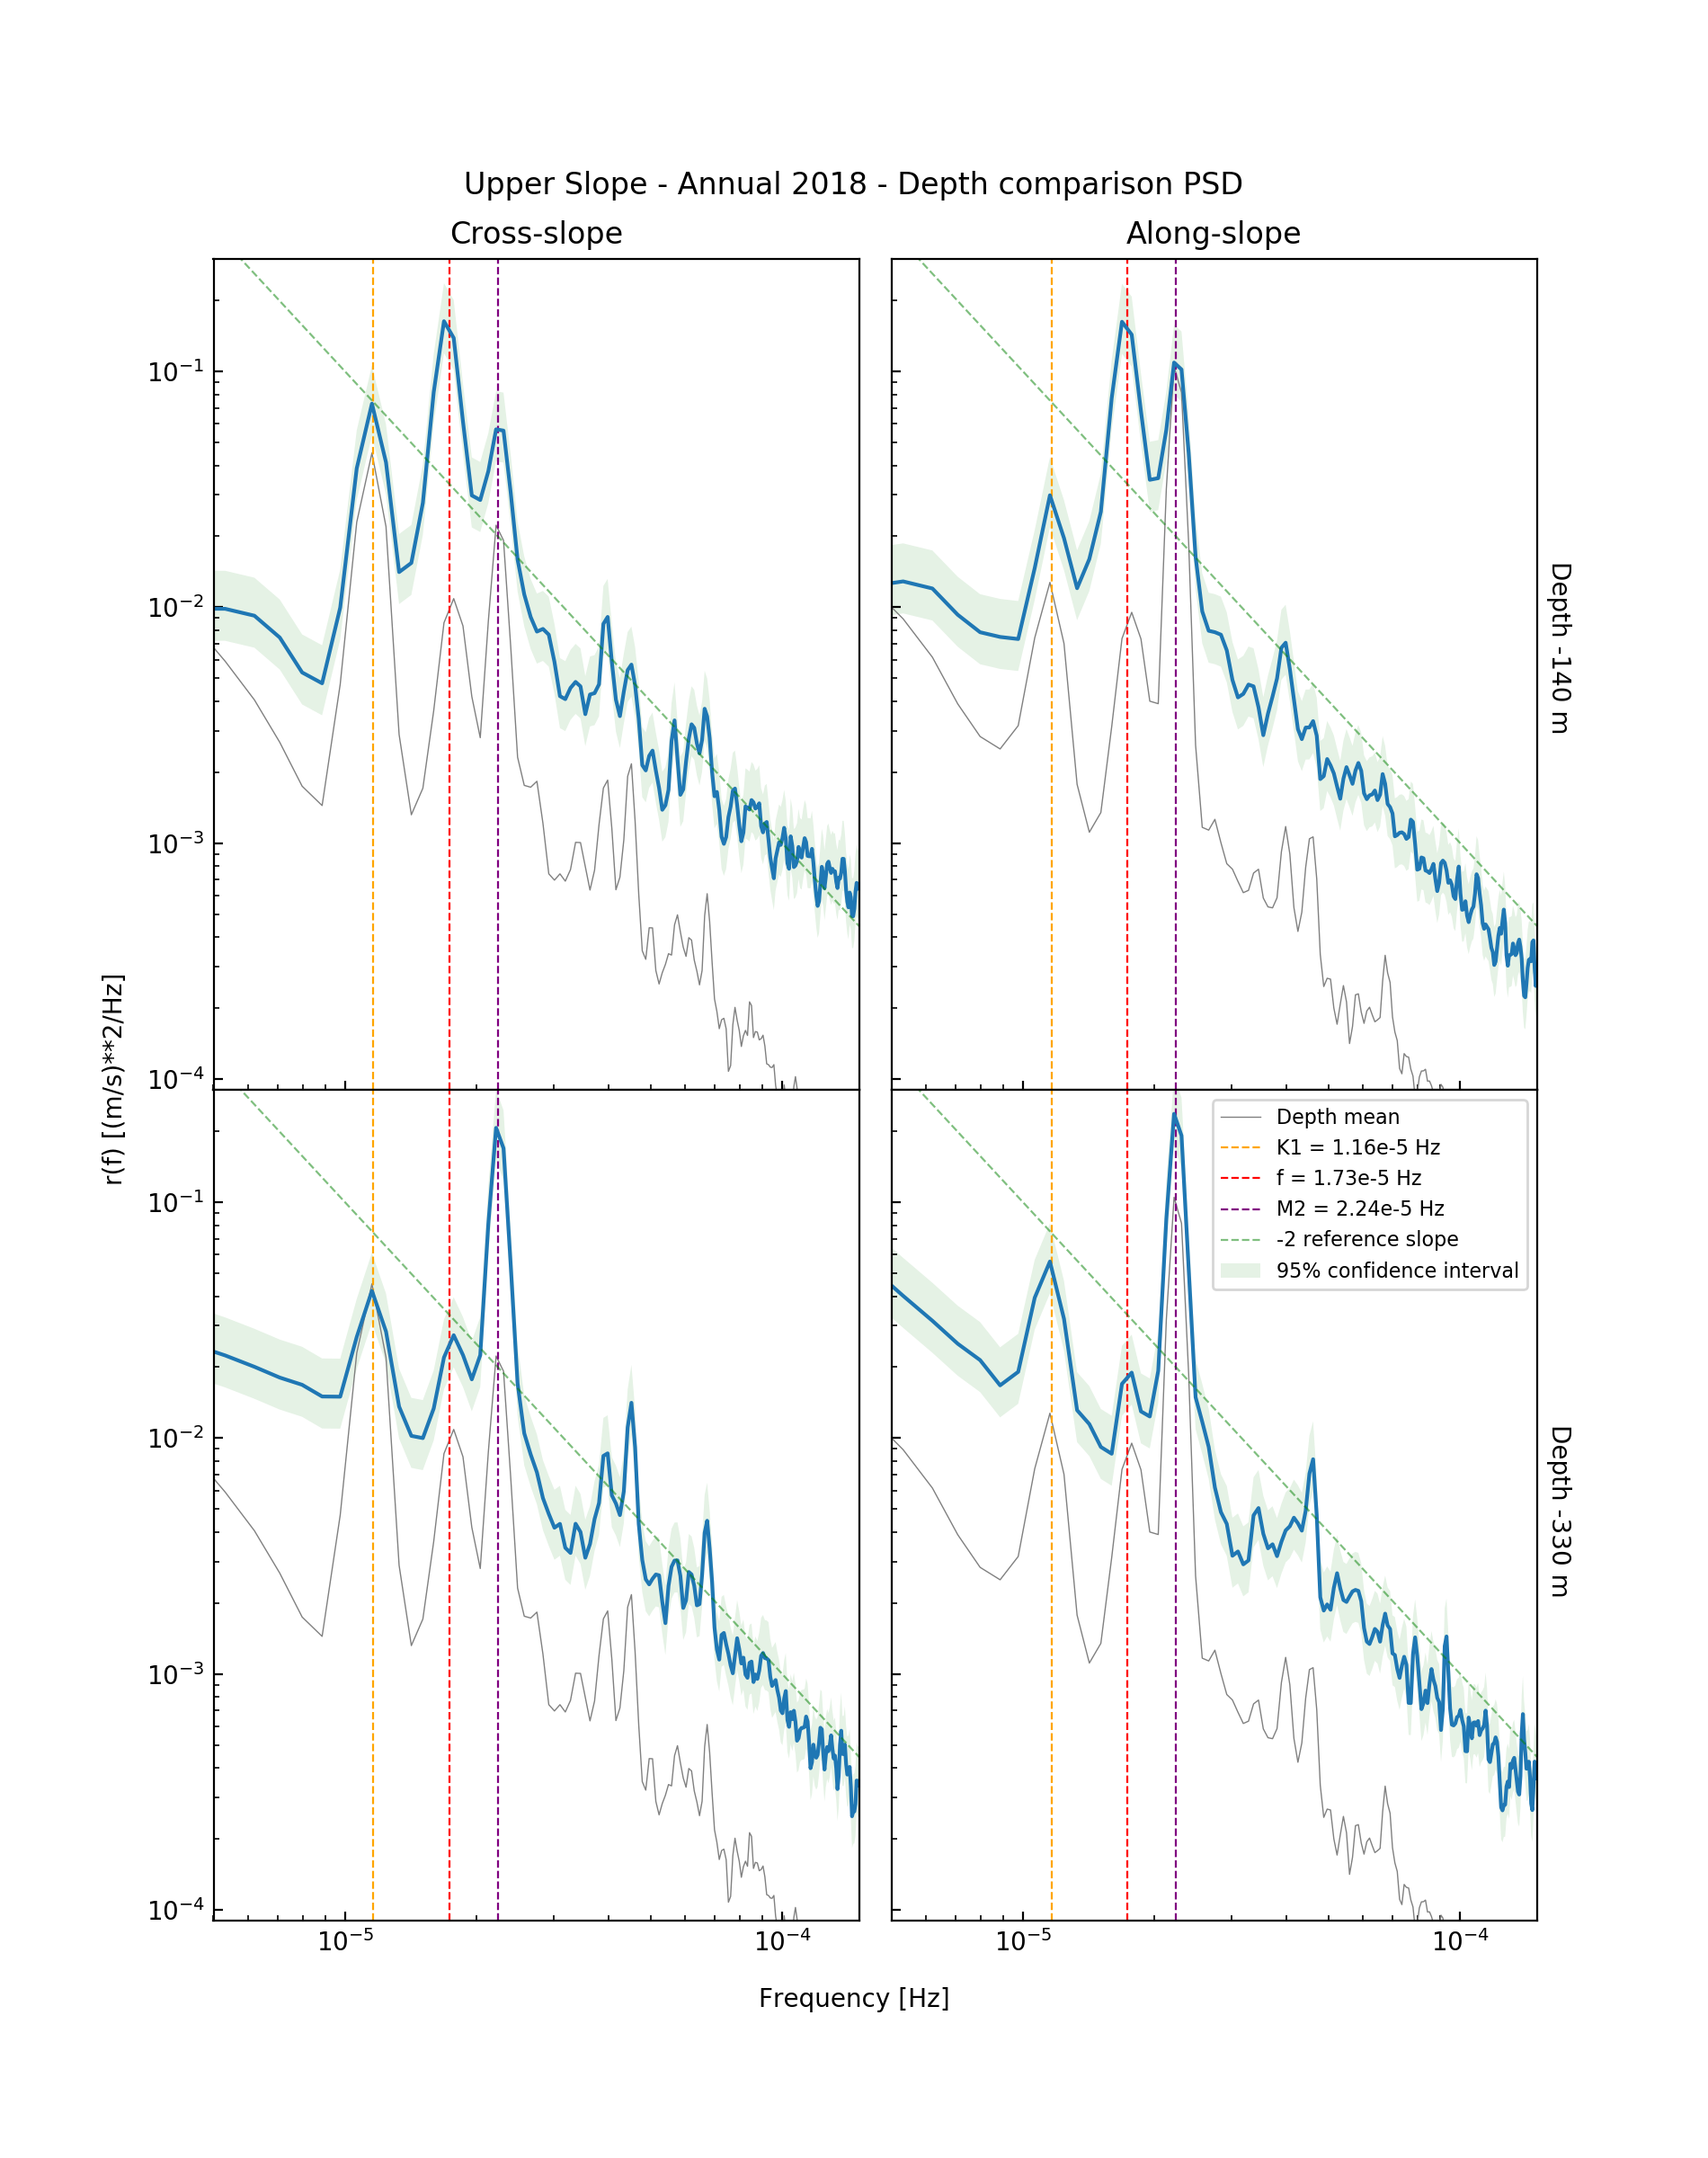

/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in power
/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in power
/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in power
/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in power


In [360]:
fig, axs = plt.subplots(2,2,figsize=(9.5,12), sharex=True, sharey=True)
(ax1,ax2),(ax3,ax4) = axs
fig.subplots_adjust(hspace=0, wspace=0.05)

ax1.loglog(um_depth_f/3600,um_depth_PSD,color='gray',lw=0.5)
ax2.loglog(vm_depth_f/3600,vm_depth_PSD,color='gray',lw=0.5)
ax3.loglog(um_depth_f/3600,um_depth_PSD,color='gray',lw=0.5)
ax4.loglog(vm_depth_f/3600,vm_depth_PSD,color='gray',lw=0.5,label='Depth mean')

ax1.axvline(1.161e-5, color ='orange',ls='--',lw=0.8,label = "K1 = 1.16e-5 Hz")
ax1.axvline(1.732e-5, color ='red',ls='--', lw=0.8,label = "f = 1.73e-5 Hz")
ax1.axvline(2.236e-5, color ='purple',ls='--',lw=0.8,label = "M2 = 2.24e-5 Hz")
ax1.loglog(umup_f/3600, umup_PSD)
ax1.tick_params(axis='both', direction='in', which='both')
ax1.set_ylim(9e-5,3e-1)
ax1.set_xlim(5e-6,1.5e-4)
ax1.set_title('Cross-slope')

ax2.axvline(1.161e-5, color ='orange',ls='--',lw=0.8,label = "K1 = 1.16e-5 Hz")
ax2.axvline(1.732e-5, color ='red',ls='--', lw=0.8,label = "f = 1.73e-5 Hz")
ax2.axvline(2.236e-5, color ='purple',ls='--',lw=0.8,label = "M2 = 2.24e-5 Hz")
ax2.tick_params(axis='both', direction='in', which='both')
ax2.loglog(vmup_f/3600, vmup_PSD)
ax2.set_title('Along-slope')

ax3.axvline(1.161e-5, color ='orange',ls='--',lw=0.8,label = "K1 = 1.16e-5 Hz")
ax3.axvline(1.732e-5, color ='red',ls='--', lw=0.8,label = "f = 1.73e-5 Hz")
ax3.axvline(2.236e-5, color ='purple',ls='--',lw=0.8,label = "M2 = 2.24e-5 Hz")
ax3.tick_params(axis='both', direction='in', which='both')
ax3.loglog(umlow_f/3600, umlow_PSD)

ax4.axvline(1.161e-5, color ='orange',ls='--',lw=0.8,label = "K1 = 1.16e-5 Hz")
ax4.axvline(1.732e-5, color ='red',ls='--', lw=0.8,label = "f = 1.73e-5 Hz")
ax4.axvline(2.236e-5, color ='purple',ls='--',lw=0.8,label = "M2 = 2.24e-5 Hz")
ax4.tick_params(axis='both', direction='in', which='both')
ax4.loglog(vmlow_f/3600, vmlow_PSD)

fig.text(0.905, 0.7, 'Depth -140 m', va='center',rotation='270')
fig.text(0.905, 0.3, 'Depth -330 m', va='center',rotation='270')
fig.text(0.5,0.91,'Upper Slope - Annual 2018 - Depth comparison PSD', ha='center', fontsize=12)
fig.text(0.06, 0.5, 'r(f) [(m/s)**2/Hz]', va='center', rotation='vertical')
fig.text(0.5,0.07,'Frequency [Hz]',ha='center')

ax1.fill_between(umup_f/3600, umup_lower, umup_upper, facecolor='green', alpha=0.1)
ax2.fill_between(vmup_f/3600, vmup_lower, vmup_upper, facecolor='green', alpha=0.1)
ax3.fill_between(umlow_f/3600, umlow_lower, umlow_upper, facecolor='green', alpha=0.1)
ax4.fill_between(vmlow_f/3600, vmlow_lower, vmlow_upper, facecolor='green', alpha=0.1, label='95% confidence interval')

ax1.loglog(umlow_f/3600,(10e-12)*(umlow_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5)
ax2.loglog(umlow_f/3600,(10e-12)*(umlow_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5)
ax3.loglog(umlow_f/3600,(10e-12)*(umlow_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5)
ax4.loglog(umlow_f/3600,(10e-12)*(umlow_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5, label='-2 reference slope')

plt.legend(loc='upper right', fontsize=8)
plt.show()

<IPython.core.display.Javascript object>


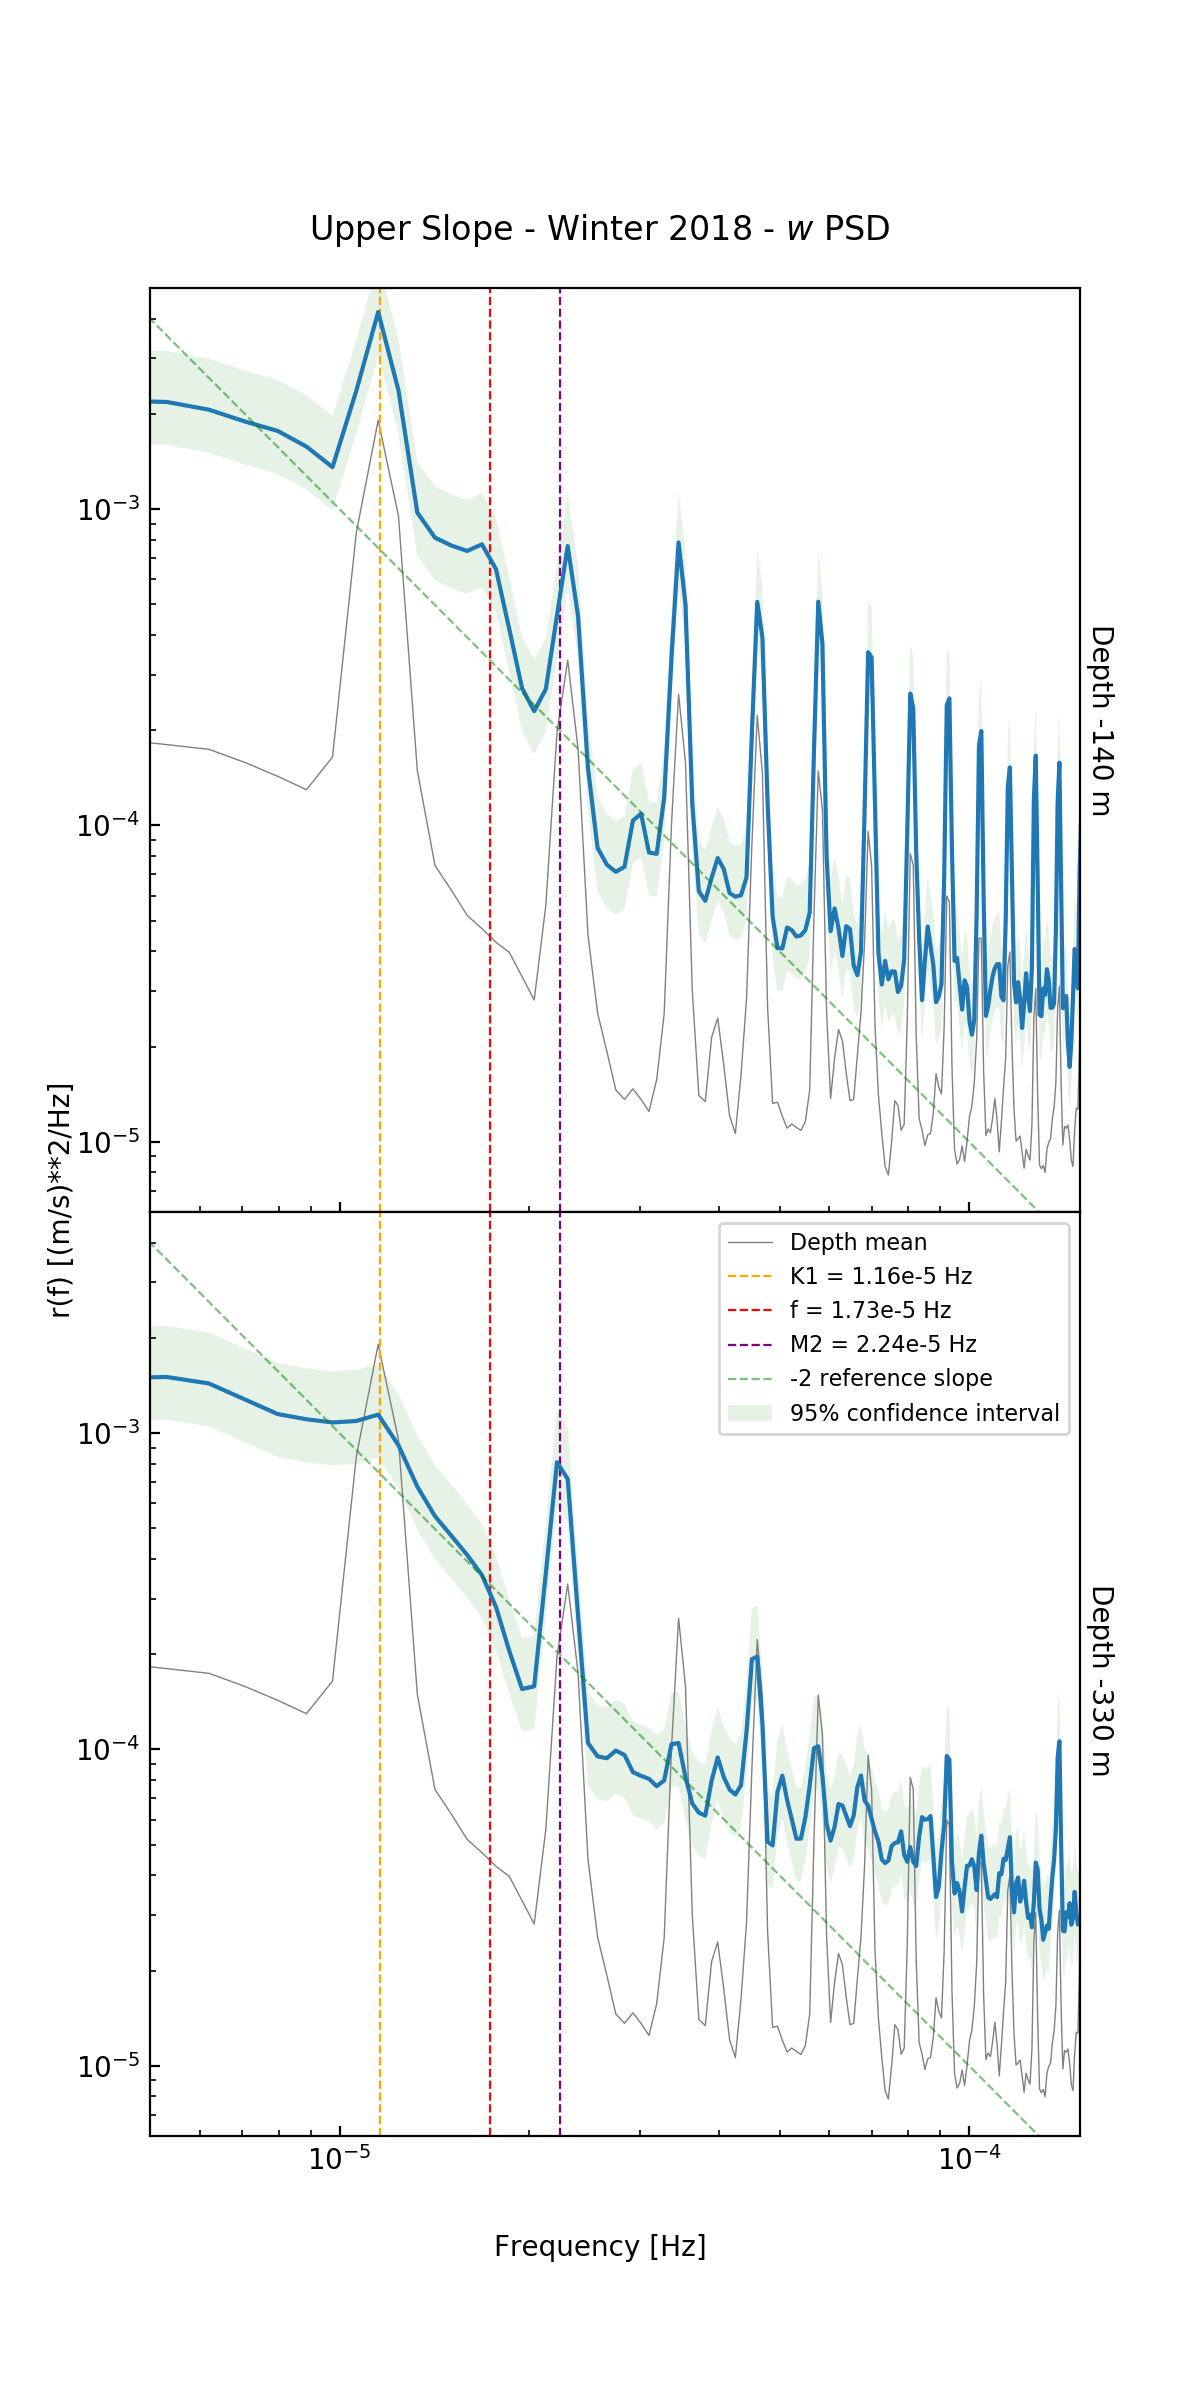

/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in power
/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in power


In [361]:
fig, axs = plt.subplots(2,1,figsize=(6,12), sharex=True, sharey=True)
(ax1,ax2) = axs
fig.subplots_adjust(hspace=0, wspace=0)

ax1.loglog(wm_depth_f/3600,wm_depth_PSD,color='gray',lw=0.5)
ax2.loglog(wm_depth_f/3600,wm_depth_PSD,color='gray',lw=0.5,label='Depth mean')

ax1.axvline(1.161e-5, color ='orange',ls='--',lw=0.8,label = "K1 = 1.16e-5 Hz")
ax1.axvline(1.732e-5, color ='red',ls='--', lw=0.8,label = "f = 1.73e-5 Hz")
ax1.axvline(2.236e-5, color ='purple',ls='--',lw=0.8,label = "M2 = 2.24e-5 Hz")
ax1.tick_params(axis='both', direction='in', which='both')
ax1.loglog(wmup_f/3600, wmup_PSD)
ax1.set_ylim(6e-6,5e-3)
ax1.set_xlim(5e-6,1.5e-4)

ax2.axvline(1.161e-5, color ='orange',ls='--',lw=0.8,label = "K1 = 1.16e-5 Hz")
ax2.axvline(1.732e-5, color ='red',ls='--', lw=0.8,label = "f = 1.73e-5 Hz")
ax2.axvline(2.236e-5, color ='purple',ls='--',lw=0.8,label = "M2 = 2.24e-5 Hz")
ax2.tick_params(axis='both', direction='in', which='both')
ax2.loglog(wmlow_f/3600, wmlow_PSD)

fig.text(0.905, 0.7, 'Depth -140 m', va='center',rotation='270')
fig.text(0.905, 0.3, 'Depth -330 m', va='center',rotation='270')
fig.text(0.5,0.90,'Upper Slope - Winter 2018 - $w$ PSD', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'r(f) [(m/s)**2/Hz]', va='center', rotation='vertical')
fig.text(0.5,0.06,'Frequency [Hz]',ha='center')

ax1.fill_between(wmup_f/3600, wmup_lower, wmup_upper, facecolor='green', alpha=0.1)
ax2.fill_between(wmlow_f/3600, wmlow_lower, wmlow_upper, facecolor='green', alpha=0.1, label='95% confidence interval')

ax1.loglog(umlow_f/3600,(10e-14)*(umlow_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5)
ax2.loglog(umlow_f/3600,(10e-14)*(umlow_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5,label='-2 reference slope')

plt.legend(loc='upper right', fontsize=8)
plt.show()

### Depth = -330 meters

<IPython.core.display.Javascript object>


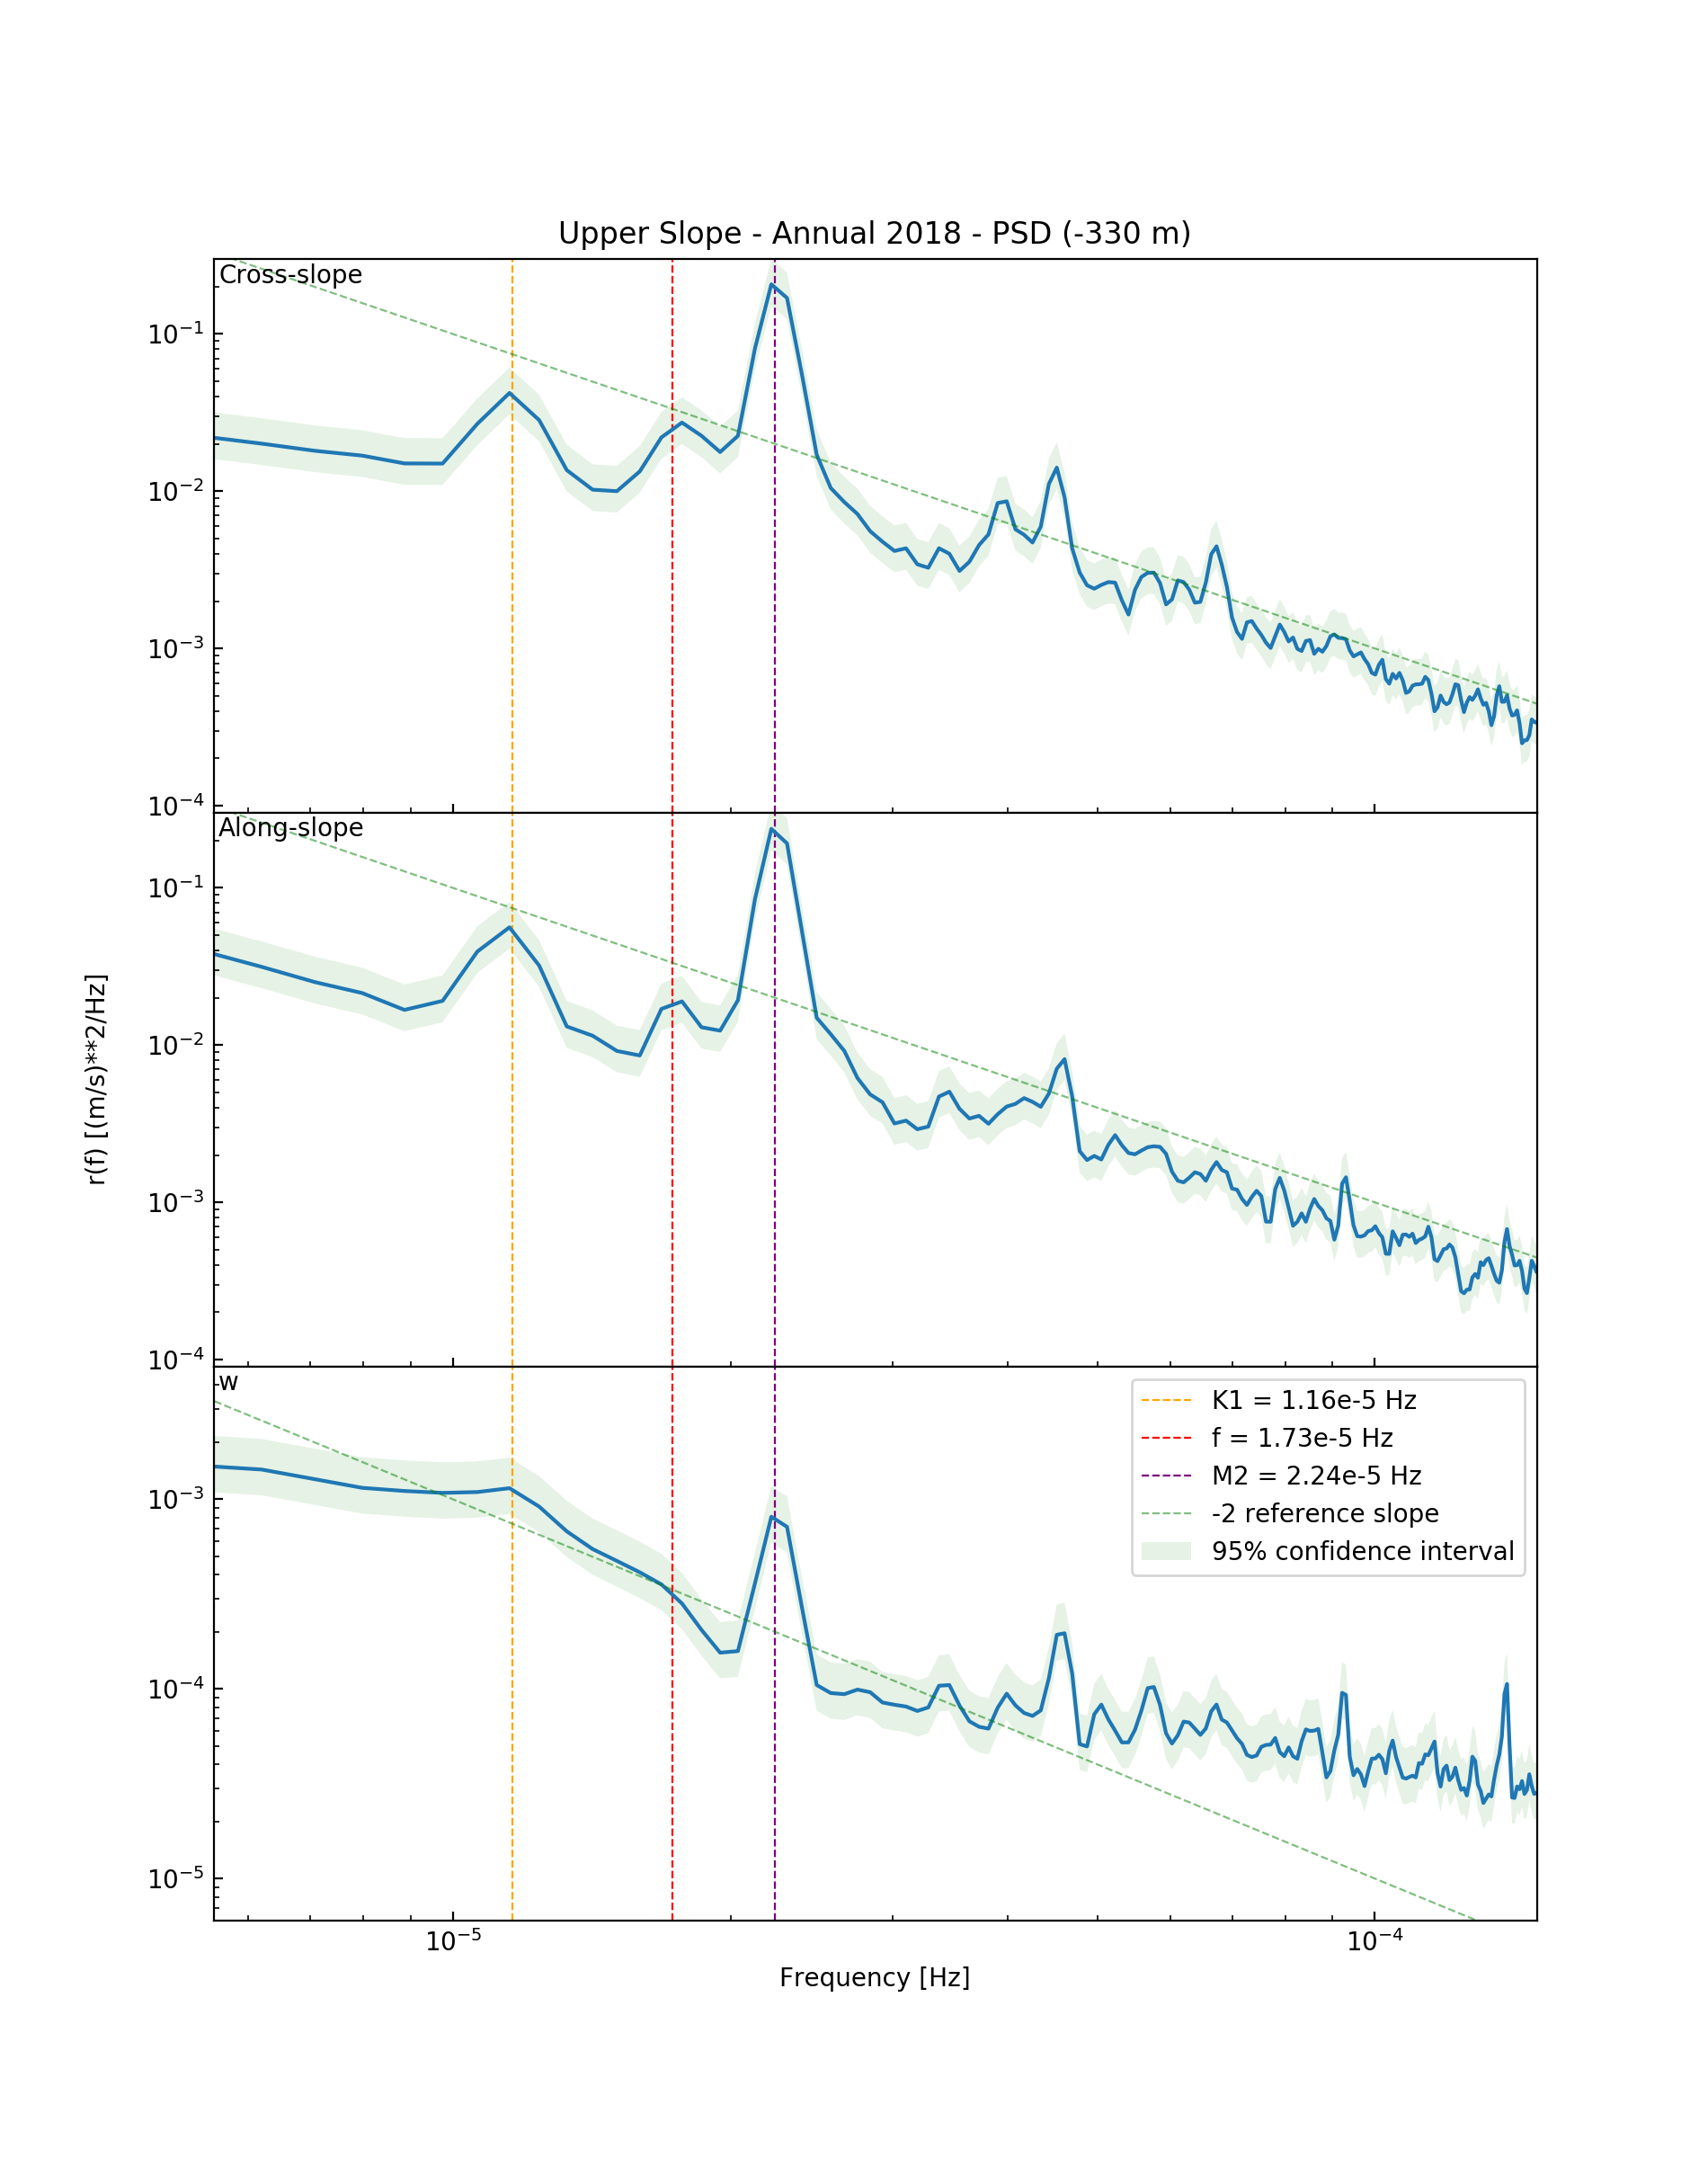

/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in power
/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in power
/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in power


In [358]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(9.5,12), sharex=True)
fig.subplots_adjust(hspace = 0.0)

ax1.axvline(1.161e-5, color ='orange',ls='--',lw=0.8,label = "K1 = 1.16e-5 Hz") # inertial period
ax1.axvline(1.732e-5, color ='red',ls='--', lw=0.8,label = "f = 1.73e-5 Hz")
ax1.axvline(2.236e-5, color ='purple',ls='--',lw=0.8,label = "M2 = 2.24e-5 Hz")
ax1.loglog(umlow_f/3600, umlow_PSD)
ax1.set_ylim(9e-5,3e-1)
ax1.set_xlim(5.5e-6,1.5e-4)
ax1.set_title('Upper Slope - Annual 2018 - PSD (-330 m)')
ax1.tick_params(axis='both', direction='in', which='both')
ax1.fill_between(umlow_f/3600, umlow_lower, umlow_upper, facecolor='green', alpha=0.1)

ax2.axvline(1.161e-5, color ='orange',ls='--',lw=0.8,label = "K1 = 1.16e-5 Hz") # inertial period
ax2.axvline(1.732e-5, color ='red',ls='--', lw=0.8,label = "f = 1.73e-5 Hz")
ax2.axvline(2.236e-5, color ='purple',ls='--',lw=0.8,label = "M2 = 2.24e-5 Hz")
ax2.loglog(vmlow_f/3600, vmlow_PSD)
ax2.set_ylim(9e-5,3e-1)
ax2.tick_params(axis='both', direction='in', which='both')
ax2.fill_between(vmlow_f/3600, vmlow_lower, vmlow_upper, facecolor='green', alpha=0.1)

ax3.axvline(1.161e-5, color ='orange',ls='--',lw=0.8,label = "K1 = 1.16e-5 Hz") # inertial period
ax3.axvline(1.732e-5, color ='red',ls='--', lw=0.8,label = "f = 1.73e-5 Hz")
ax3.axvline(2.236e-5, color ='purple',ls='--',lw=0.8,label = "M2 = 2.24e-5 Hz")
ax3.loglog(wmlow_f/3600, wmlow_PSD)
ax3.set_ylim(6e-6,5e-3)
ax3.set_xlabel('Frequency [Hz]')
ax3.tick_params(axis='both', direction='in', which='both')
ax3.fill_between(wmlow_f/3600, wmlow_lower, wmlow_upper, facecolor='green', alpha=0.1, label='95% confidence interval')

ax1.loglog(umlow_f/3600,(10e-12)*(umlow_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5)
ax2.loglog(umlow_f/3600,(10e-12)*(umlow_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5)
ax3.loglog(umlow_f/3600,(10e-14)*(umlow_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5, label='-2 reference slope')

fig.text(0.05, 0.5, 'r(f) [(m/s)**2/Hz]', va='center', rotation='vertical')
fig.text(0.128, 0.872, 'Cross-slope', va='center')
fig.text(0.128, 0.616, 'Along-slope', va='center')
fig.text(0.128, 0.359, 'w', va='center')

plt.legend(loc='upper right')
plt.show()

### Depth = -140 meters

In [359]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(9.5,12), sharex=True)
fig.subplots_adjust(hspace = 0.0)

ax1.axvline(1.161e-5, color ='orange',ls='--',lw=0.8,label = "K1 = 1.16e-5 Hz")
ax1.axvline(1.732e-5, color ='red',ls='--', lw=0.8,label = "f = 1.73e-5 Hz")
ax1.axvline(2.236e-5, color ='purple',ls='--',lw=0.8,label = "M2 = 2.24e-5 Hz")
ax1.loglog(umup_f/3600, umup_PSD)
ax1.set_ylim(9e-5,3e-1)
ax1.set_xlim(5.5e-6,1.5e-4)
ax1.tick_params(axis='both', direction='in', which='both')
ax1.set_title('Upper Slope - Annual 2018 - PSD (-140 m)')

ax2.axvline(1.161e-5, color ='orange',ls='--',lw=0.8,label = "K1 = 1.16e-5 Hz")
ax2.axvline(1.732e-5, color ='red',ls='--', lw=0.8,label = "f = 1.73e-5 Hz")
ax2.axvline(2.236e-5, color ='purple',ls='--',lw=0.8,label = "M2 = 2.24e-5 Hz")
ax2.loglog(vmup_f/3600, vmup_PSD)
ax2.set_ylim(9e-5,3e-1)
ax2.tick_params(axis='both', direction='in', which='both')

ax3.axvline(1.161e-5, color ='orange',ls='--',lw=0.8,label = "K1 = 1.16e-5 Hz")
ax3.axvline(1.732e-5, color ='red',ls='--', lw=0.8,label = "f = 1.73e-5 Hz")
ax3.axvline(2.236e-5, color ='purple',ls='--',lw=0.8,label = "M2 = 2.24e-5 Hz")
ax3.loglog(wmup_f/3600, wmup_PSD)
ax3.set_ylim(6e-6,5e-3)
ax3.set_xlabel('Frequency [Hz]')
ax3.tick_params(axis='both', direction='in', which='both')

ax1.fill_between(umup_f/3600, umup_lower, umup_upper, facecolor='green', alpha=0.1)
ax2.fill_between(vmup_f/3600, vmup_lower, vmup_upper, facecolor='green', alpha=0.1)
ax3.fill_between(wmup_f/3600, wmup_lower, wmup_upper, facecolor='green', alpha=0.1, label='95% confidence interval')

ax1.loglog(umup_f/3600,(10e-12)*(umup_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5)
ax2.loglog(umup_f/3600,(10e-12)*(umup_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5)
ax3.loglog(umup_f/3600,(10e-14)*(umup_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5, label='-2 reference slope')

fig.text(0.05, 0.5, 'r(f) [(m/s)**2/Hz]', va='center', rotation='vertical')
fig.text(0.128, 0.872, 'Cross-slope', va='center')
fig.text(0.128, 0.616, 'Along-slope', va='center')
fig.text(0.128, 0.359, 'w', va='center')

plt.legend(loc='upper right')
plt.show()

<IPython.core.display.Javascript object>

/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in power
/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in power
/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in power


## Velocities

Plots for cross-slope, along-slope, w (original, filtered, and residual) data

### Comparative velocities

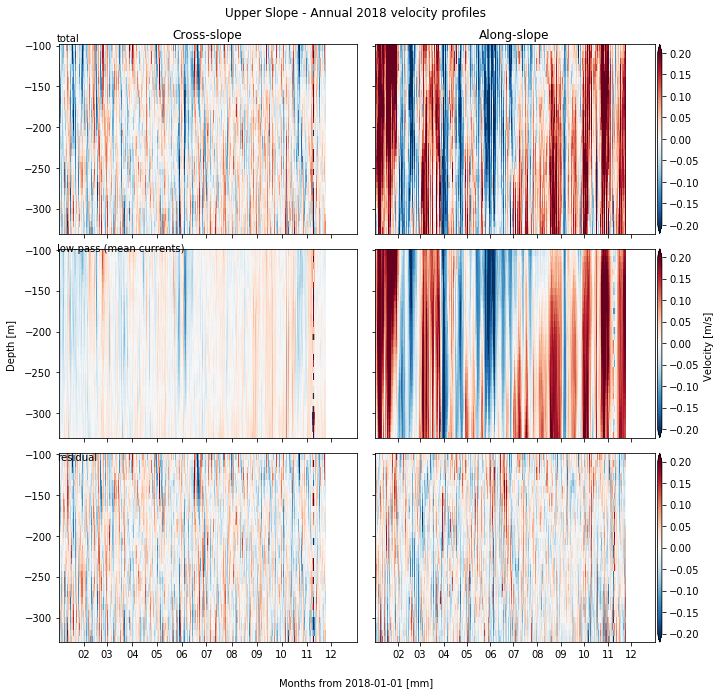

In [40]:
# plot comparative data

fig, axs = plt.subplots(3,2, figsize=(11,11), sharex = True, sharey = True)
(ax1,ax4),(ax2,ax5),(ax3,ax6) = axs
fig.subplots_adjust(hspace = 0.08,wspace = 0.06)
fig.text(0.5, 0.915, 'Upper Slope - Annual 2018 velocity profiles', ha='center', fontsize=12)
fig.text(0.06, 0.5, 'Depth [m]', va='center', rotation='vertical')
fig.text(0.123, 0.887, 'total', va='center')
fig.text(0.123, 0.622, 'low-pass (mean currents)', va='center')
fig.text(0.123, 0.359, 'residual', va='center')
fig.text(0.94, 0.5, 'Velocity [m/s]', va='center', rotation='vertical')
fig.text(0.5, 0.07, f'Months from {datestimes.dt.date[start]} [mm]', ha='center')
ax1.set_title('Cross-slope')
ax4.set_title('Along-slope')

im1 = ax1.pcolormesh(time, -depth, uorig.T, rasterized=True, cmap='RdBu_r', vmin=-0.20, vmax=0.20)
im2 = ax2.pcolormesh(time, -depth, ulp.T, rasterized=True, cmap='RdBu_r', vmin=-0.20, vmax=0.20)
im3 = ax3.pcolormesh(time, -depth, uhp.T, rasterized=True, cmap='RdBu_r', vmin=-0.20, vmax=0.20)
im4 = ax4.pcolormesh(time, -depth, vorig.T, rasterized=True, cmap='RdBu_r', vmin=-0.2, vmax=0.2)
cbar4 = fig.colorbar(im4, ax=ax4, fraction=0.05, pad=0.01, aspect=40, extend='both')
im5 = ax5.pcolormesh(time, -depth, vlp.T, rasterized=True, cmap='RdBu_r', vmin=-0.2, vmax=0.2)
cbar5 = fig.colorbar(im5, ax=ax5, fraction=0.05, pad=0.01, aspect=40, extend='both')
im6 = ax6.pcolormesh(time, -depth, vhp.T, rasterized=True, cmap='RdBu_r', vmin=-0.2, vmax=0.2)
cbar6 = fig.colorbar(im6, ax=ax6, fraction=0.05, pad=0.01, aspect=40, extend='both')

date_form = pldates.DateFormatter("%m")
ax6.xaxis.set_major_formatter(date_form)
ax6.set_xlim([time_total[0], time_total[-1]])
plt.show()

### Cross-slope

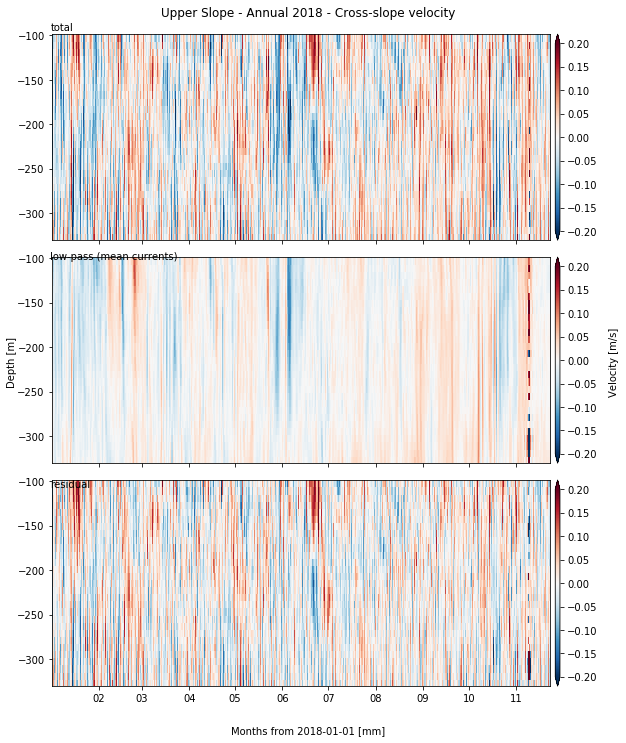

In [22]:
# plot cross-slope data

fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(9.5,12), sharex = True)
fig.subplots_adjust(hspace = 0.08)
fig.text(0.5, 0.9, 'Upper Slope - Annual 2018 - Cross-slope velocity', ha='center', fontsize=12)
fig.text(0.06, 0.5, 'Depth [m]', va='center', rotation='vertical')
fig.text(0.123, 0.887, 'total', va='center')
fig.text(0.123, 0.622, 'low-pass (mean currents)', va='center')
fig.text(0.123, 0.359, 'residual', va='center')
fig.text(0.94, 0.5, 'Velocity [m/s]', va='center', rotation='vertical')
fig.text(0.5, 0.07, f'Months from {datestimes.dt.date[start]} [mm]', ha='center')

im1 = ax1.pcolormesh(time, -depth, uorig.T, rasterized=True, cmap='RdBu_r', vmin=-0.20, vmax=0.20)
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=40, extend='both')

im2 = ax2.pcolormesh(time, -depth, ulp.T, rasterized=True, cmap='RdBu_r', vmin=-0.20, vmax=0.20)
cbar2 = fig.colorbar(im2, ax=ax2, fraction=0.05, pad=0.01, aspect=40, extend='both')

im3 = ax3.pcolormesh(time, -depth, uhp.T, rasterized=True, cmap='RdBu_r', vmin=-0.20, vmax=0.20)
cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.05, pad=0.01, aspect=40, extend='both')

date_form = pldates.DateFormatter("%m")
ax3.xaxis.set_major_formatter(date_form)

### Along-slope

In [366]:
# plot along-slope data

fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(9.5,12), sharex = True)
fig.subplots_adjust(hspace = 0.08)
fig.text(0.5, 0.9, 'Upper Slope - Annual 2018 - Along-slope velocity', ha='center', fontsize=12)
fig.text(0.06, 0.5, 'Depth [m]', va='center', rotation='vertical')
fig.text(0.123, 0.887, 'total', va='center')
fig.text(0.123, 0.622, 'low-pass (mean currents)', va='center')
fig.text(0.123, 0.359, 'residual', va='center')
fig.text(0.94, 0.5, 'Velocity [m/s]', va='center', rotation='vertical')
fig.text(0.5, 0.07, f'Months from {datestimes.dt.date[start]} [mm]', ha='center')

im1 = ax1.pcolormesh(time, -depth, vorig.T, rasterized=True, cmap='RdBu_r', vmin=-0.2, vmax=0.2)
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=40, extend='both')

im2 = ax2.pcolormesh(time, -depth, vlp.T, rasterized=True, cmap='RdBu_r', vmin=-0.2, vmax=0.2)
cbar2 = fig.colorbar(im2, ax=ax2, fraction=0.05, pad=0.01, aspect=40, extend='both')

im3 = ax3.pcolormesh(time, -depth, vhp.T, rasterized=True, cmap='RdBu_r', vmin=-0.2, vmax=0.2)
cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.05, pad=0.01, aspect=40, extend='both')

date_form = pldates.DateFormatter("%m/%d")
ax3.xaxis.set_major_formatter(date_form)

<IPython.core.display.Javascript object>

### w

<IPython.core.display.Javascript object>


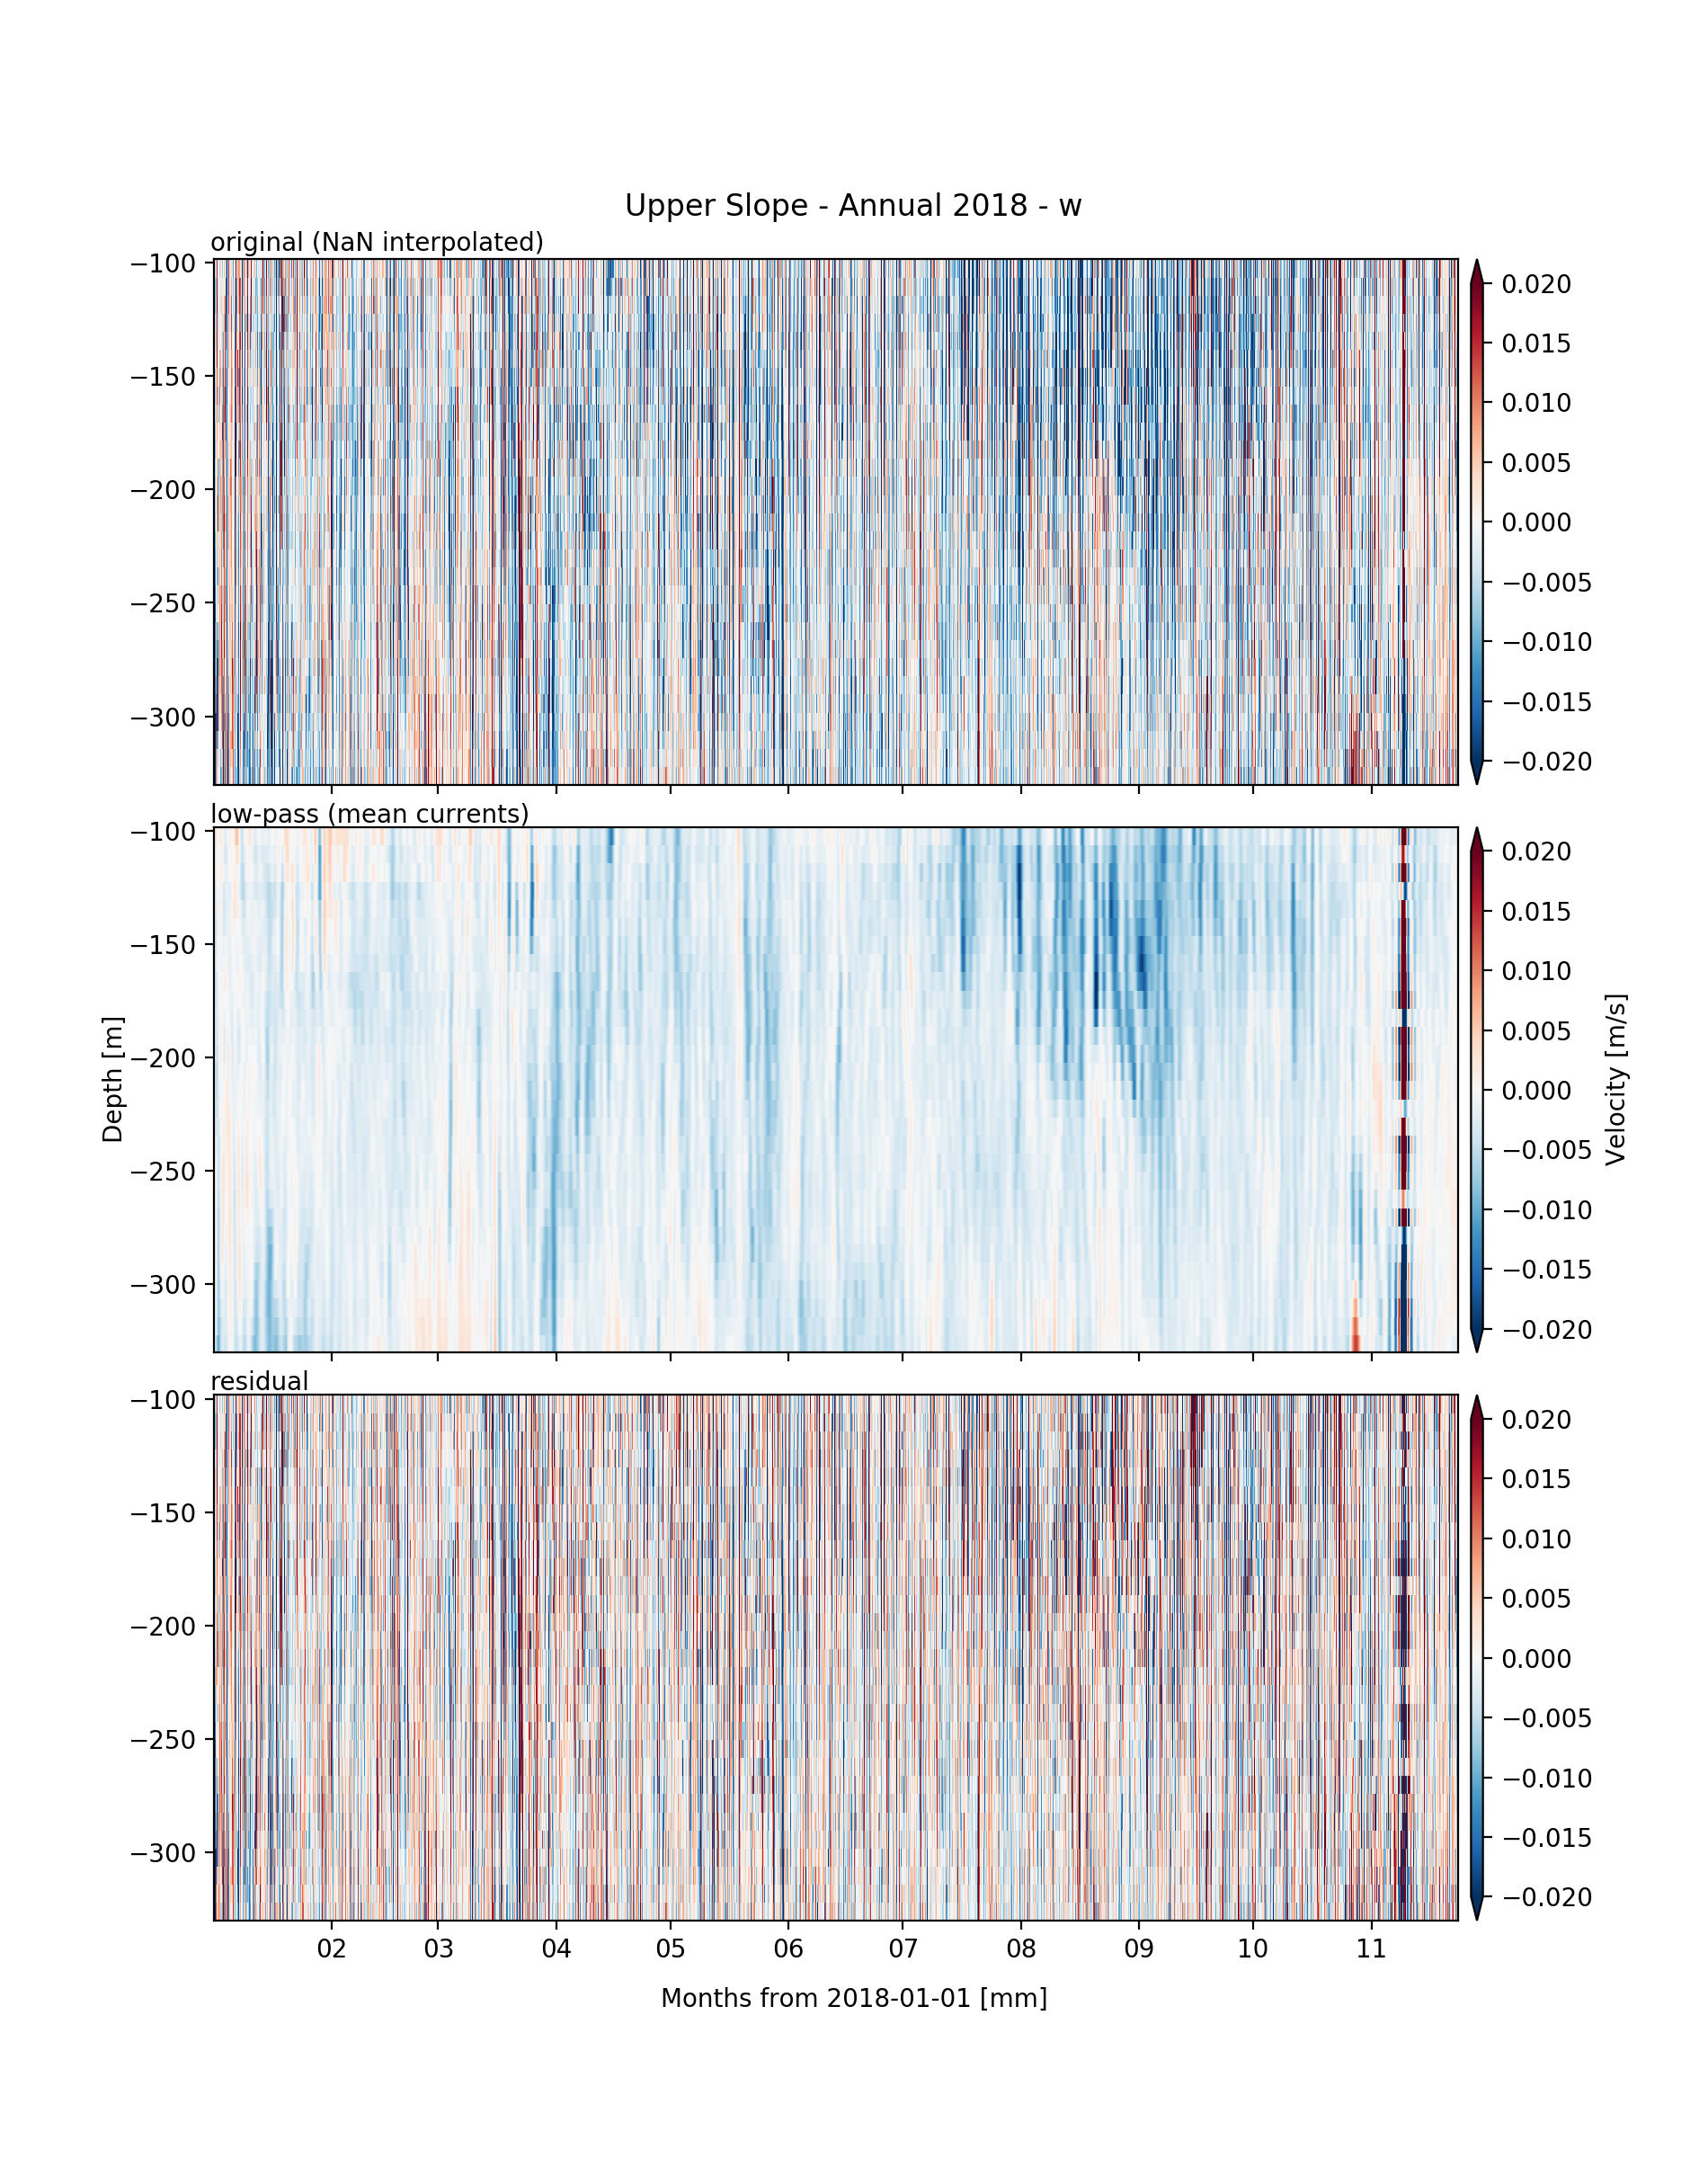

In [367]:
# plot w data

fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(9.5,12), sharex = True)
fig.subplots_adjust(hspace = 0.08)
fig.text(0.5, 0.9, 'Upper Slope - Annual 2018 - w', ha='center', fontsize=12)
fig.text(0.06, 0.5, 'Depth [m]', va='center', rotation='vertical')
fig.text(0.123, 0.887, 'original (NaN interpolated)', va='center')
fig.text(0.123, 0.622, 'low-pass (mean currents)', va='center')
fig.text(0.123, 0.359, 'residual', va='center')
fig.text(0.94, 0.5, 'Velocity [m/s]', va='center', rotation='vertical')
fig.text(0.5, 0.07, f'Months from {datestimes.dt.date[start]} [mm]', ha='center')

im1 = ax1.pcolormesh(time, -depth, worig.T, rasterized=True, cmap='RdBu_r', vmin=-0.02, vmax=0.02)
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=40, extend='both')

im2 = ax2.pcolormesh(time, -depth, wlp.T, rasterized=True, cmap='RdBu_r', vmin=-0.02, vmax=0.02)
cbar2 = fig.colorbar(im2, ax=ax2, fraction=0.05, pad=0.01, aspect=40, extend='both')

im3 = ax3.pcolormesh(time, -depth, whp.T, rasterized=True, cmap='RdBu_r', vmin=-0.02, vmax=0.02)
cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.05, pad=0.01, aspect=40, extend='both')

date_form = pldates.DateFormatter("%m")
ax3.xaxis.set_major_formatter(date_form)